In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.global_interpretation.tree_surrogate import TreeSurrogate
#from skater.util.dataops import show_in_notebook ##??
from alepython.ale import ale_plot

import warnings
warnings.simplefilter("ignore")

In [6]:
#This class is needed to get the probability of each protein class for the ALE plots
class one_class_prob_pred:
    def __init__(self, predictor: callable, class_no: int):
        self.predictor = predictor
        self.class_no = class_no

    def predict(self, X, **kwargs):
        return self.predictor(X,**kwargs)[:,self.class_no]

In [7]:
featureNames = ["seq", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "loc"]
yeastData = pd.read_csv("yeast.data", sep=" ", names=featureNames)
kFold = KFold(n_splits=2, shuffle=False)
yeastAttrib = yeastData.iloc[:,1:9].values  # fix column indexes
yeastTarget = yeastData["loc"].values

# titles = ("GradientBoost", "KNN", "Gaussian", "Random Forest", "MLP") # add more
# models = (GradientBoostingClassifier(n_estimators=100, max_features=None, max_depth=2, random_state=5),
#             KNeighborsClassifier(),
#             GaussianNB(),
#             RandomForestClassifier(),
#             MLPClassifier())
model = MLPClassifier()
dummy = DummyClassifier()

------------Fold 1
Dummy prediction
             precision    recall  f1-score   support

        CYT       0.25      0.34      0.29       198
        ERL       0.00      0.00      0.00         5
        EXC       0.00      0.00      0.00        19
        ME1       0.00      0.00      0.00        17
        ME2       0.06      0.03      0.04        33
        ME3       0.12      0.16      0.14        74
        MIT       0.26      0.10      0.14       180
        NUC       0.26      0.29      0.28       197
        POX       0.00      0.00      0.00        14
        VAC       0.00      0.00      0.00         5

avg / total       0.21      0.21      0.20       742

MLP
             precision    recall  f1-score   support

        CYT       0.38      0.72      0.50       198
        ERL       0.00      0.00      0.00         5
        EXC       0.00      0.00      0.00        19
        ME1       0.33      0.82      0.47        17
        ME2       0.00      0.00      0.00        33
  

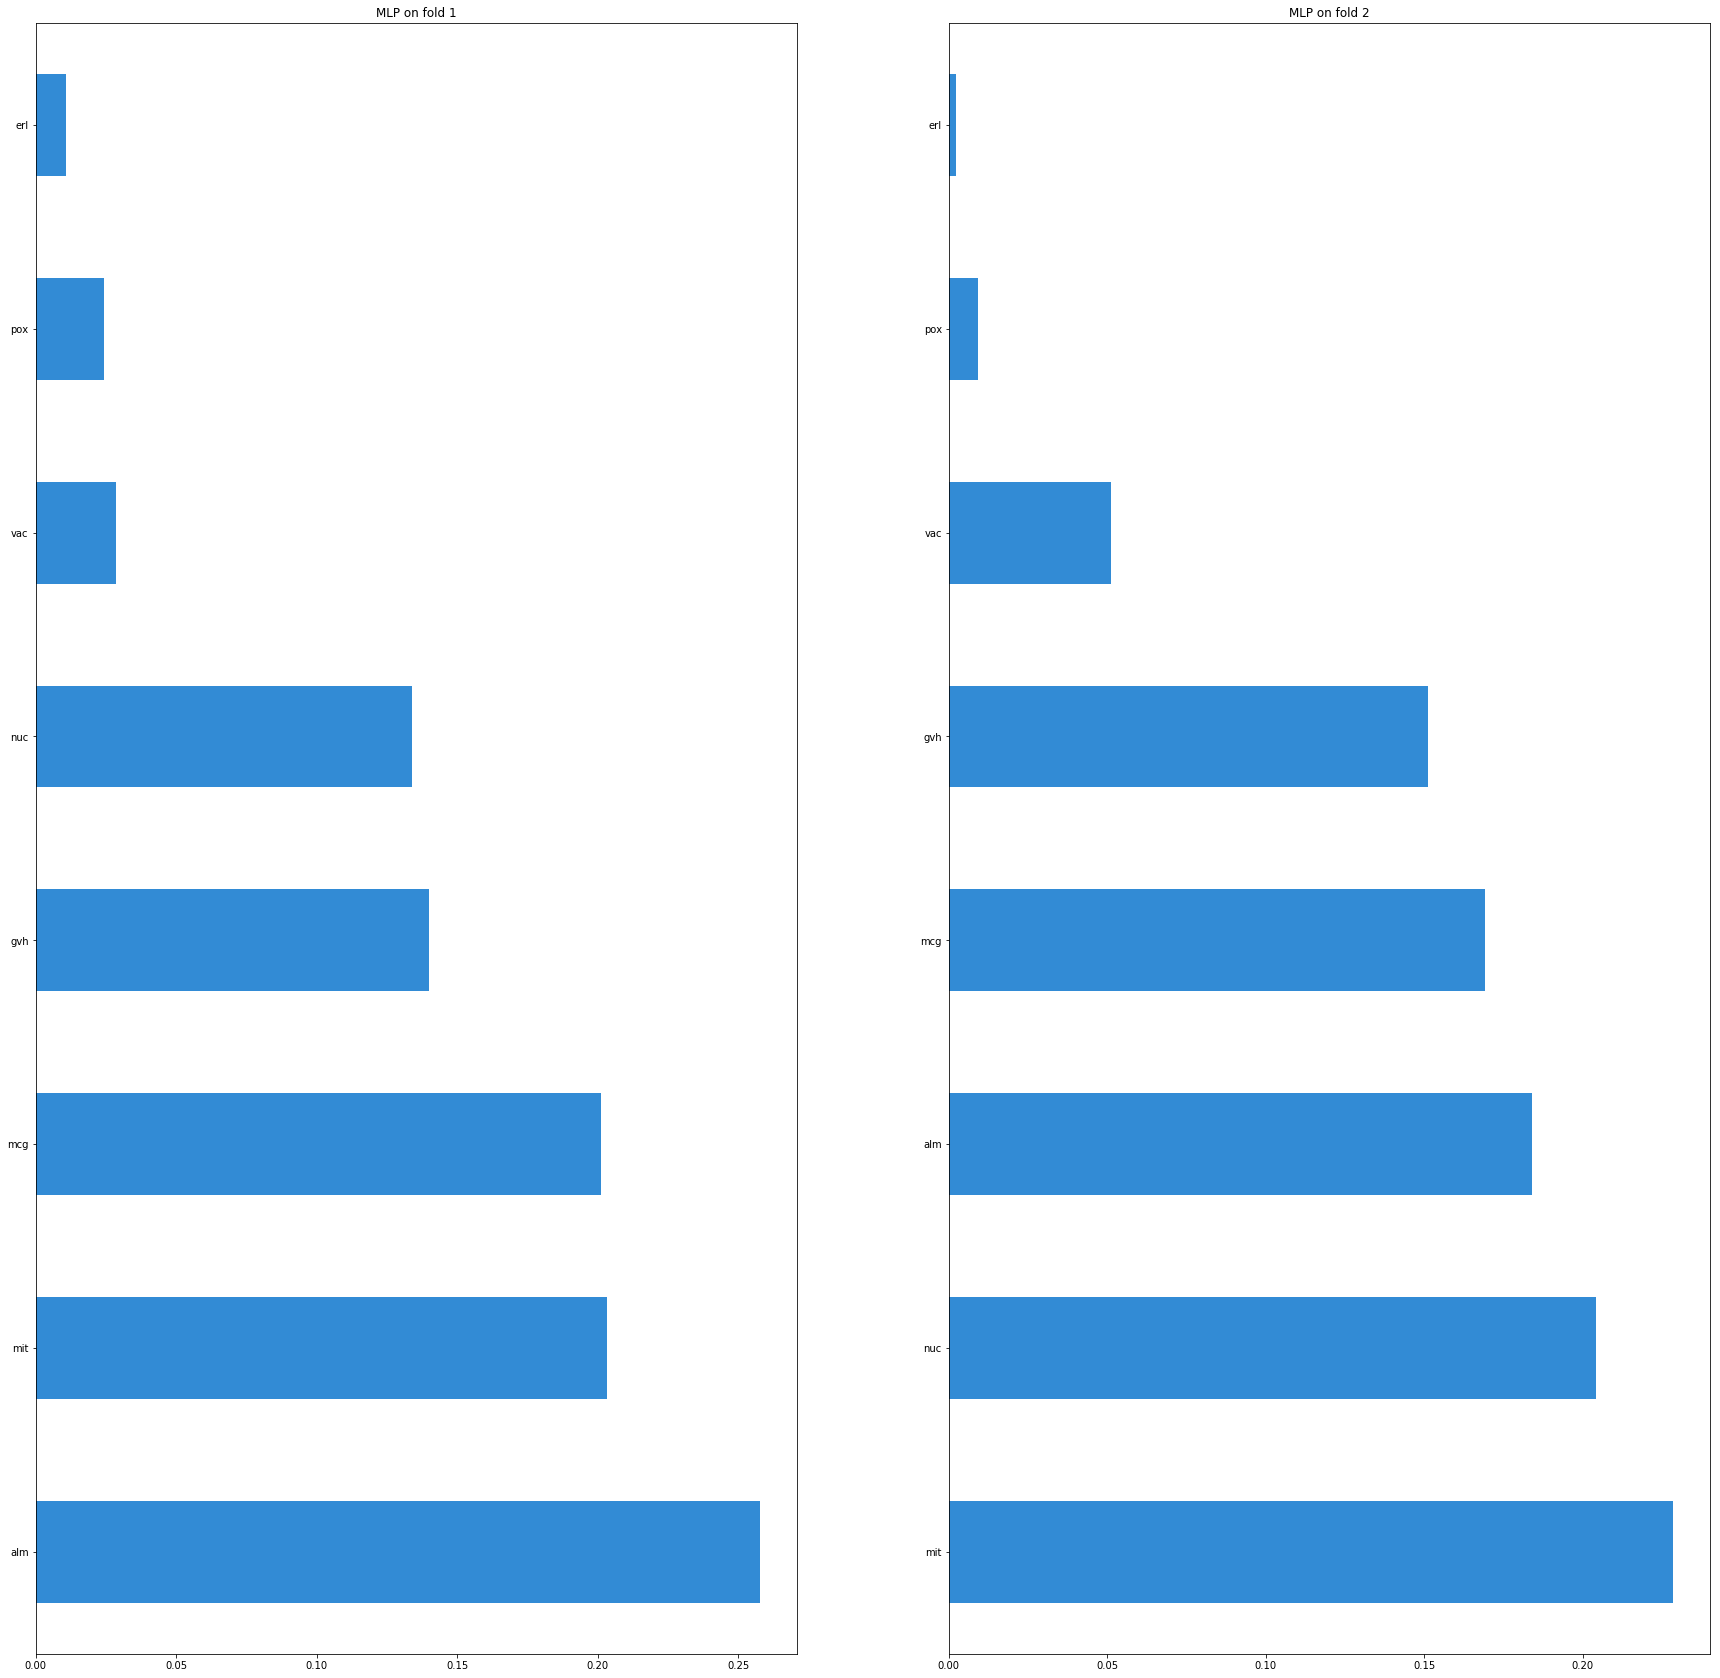

In [15]:
# Entire dataset tests
fold = 1
fig, axs = plt.subplots(1, kFold.n_splits)
for train_index, test_index in kFold.split(yeastAttrib):
    print(f"------------"
          f"Fold {fold}")
    train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
    test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
    dummy.fit(train_data, train_target)
    prediction = dummy.predict(test_data)
    print("Dummy prediction")
    print(classification_report(test_target, prediction))
    
    clf = model.fit(train_data, train_target)
    prediction = clf.predict(test_data)
    print(f"MLP")
    print(classification_report(test_target, prediction))
    print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

    ax = axs[fold - 1]
    interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
    model_mem = InMemoryModel(model.predict_proba, examples=test_data)
    interpreter.feature_importance.plot_feature_importance(model_mem, ascending=False, ax=ax, progressbar=False)
    ax.set_title(f"MLP on fold {fold}")
    
    print("\n")
    fold += 1
plt.rcParams["figure.figsize"] = (30,30)

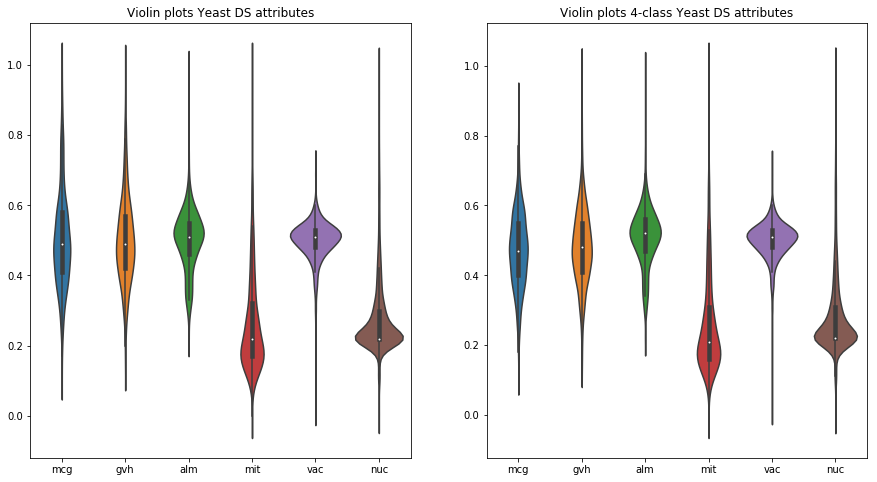

In [46]:
yeast4Classes = yeastData.loc[(yeastData["loc"] == "CYT")|( yeastData["loc"] == "NUC" )| (yeastData["loc"] == "MIT" )| (yeastData["loc"] == "ME3")]
yeastAttrib = yeast4Classes.iloc[:, 1:9].values  # fix column indexes
yeastTarget = yeast4Classes["loc"].values
plt.rcParams["figure.figsize"] = (15,8)
plt.subplot(1,2,1)
plt.title("Violin plots Yeast DS attributes")
ax = sns.violinplot(data=yeastData.iloc[:, [1, 2, 3, 4, 7, 8]], orient="v")
plt.subplot(1, 2, 2)
plt.title("Violin plots 4-class Yeast DS attributes")
ax = sns.violinplot(data=yeast4Classes.iloc[:, [1, 2, 3, 4, 7, 8]], orient="v")

------------Fold 1
Dummy prediction
             precision    recall  f1-score   support

        CYT       0.31      0.27      0.29       198
        ERL       0.00      0.00      0.00         0
        EXC       0.00      0.00      0.00         0
        ME1       0.00      0.00      0.00         0
        ME2       0.00      0.00      0.00         0
        ME3       0.15      0.12      0.13        75
        MIT       0.29      0.26      0.27       180
        NUC       0.28      0.23      0.25       197
        POX       0.00      0.00      0.00         0
        VAC       0.00      0.00      0.00         0

avg / total       0.27      0.24      0.25       650

MLP
             precision    recall  f1-score   support

        CYT       0.43      0.77      0.55       198
        ME3       0.77      0.81      0.79        75
        MIT       0.82      0.38      0.52       180
        NUC       0.64      0.42      0.50       197

avg / total       0.64      0.56      0.55       650



2019-07-05 21:46:40,199 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[22/22] grid cells ████████████████████ Time elapsed: 1 seconds

2019-07-05 21:46:41,797 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[70/70] grid cells ████████████████████ Time elapsed: 5 seconds

2019-07-05 21:46:47,604 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2019-07-05 21:46:47,609 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2019-07-05 21:46:47,611 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 0.339765558946229
2019-07-05 21:46:47,638 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [3]
2019-07-05 21:46:47,639 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (650, 4)
2019-07-05 21:46:47,650 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.348; oracle score 0.847
2019-07-05 21:46:47,651 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.499 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is t

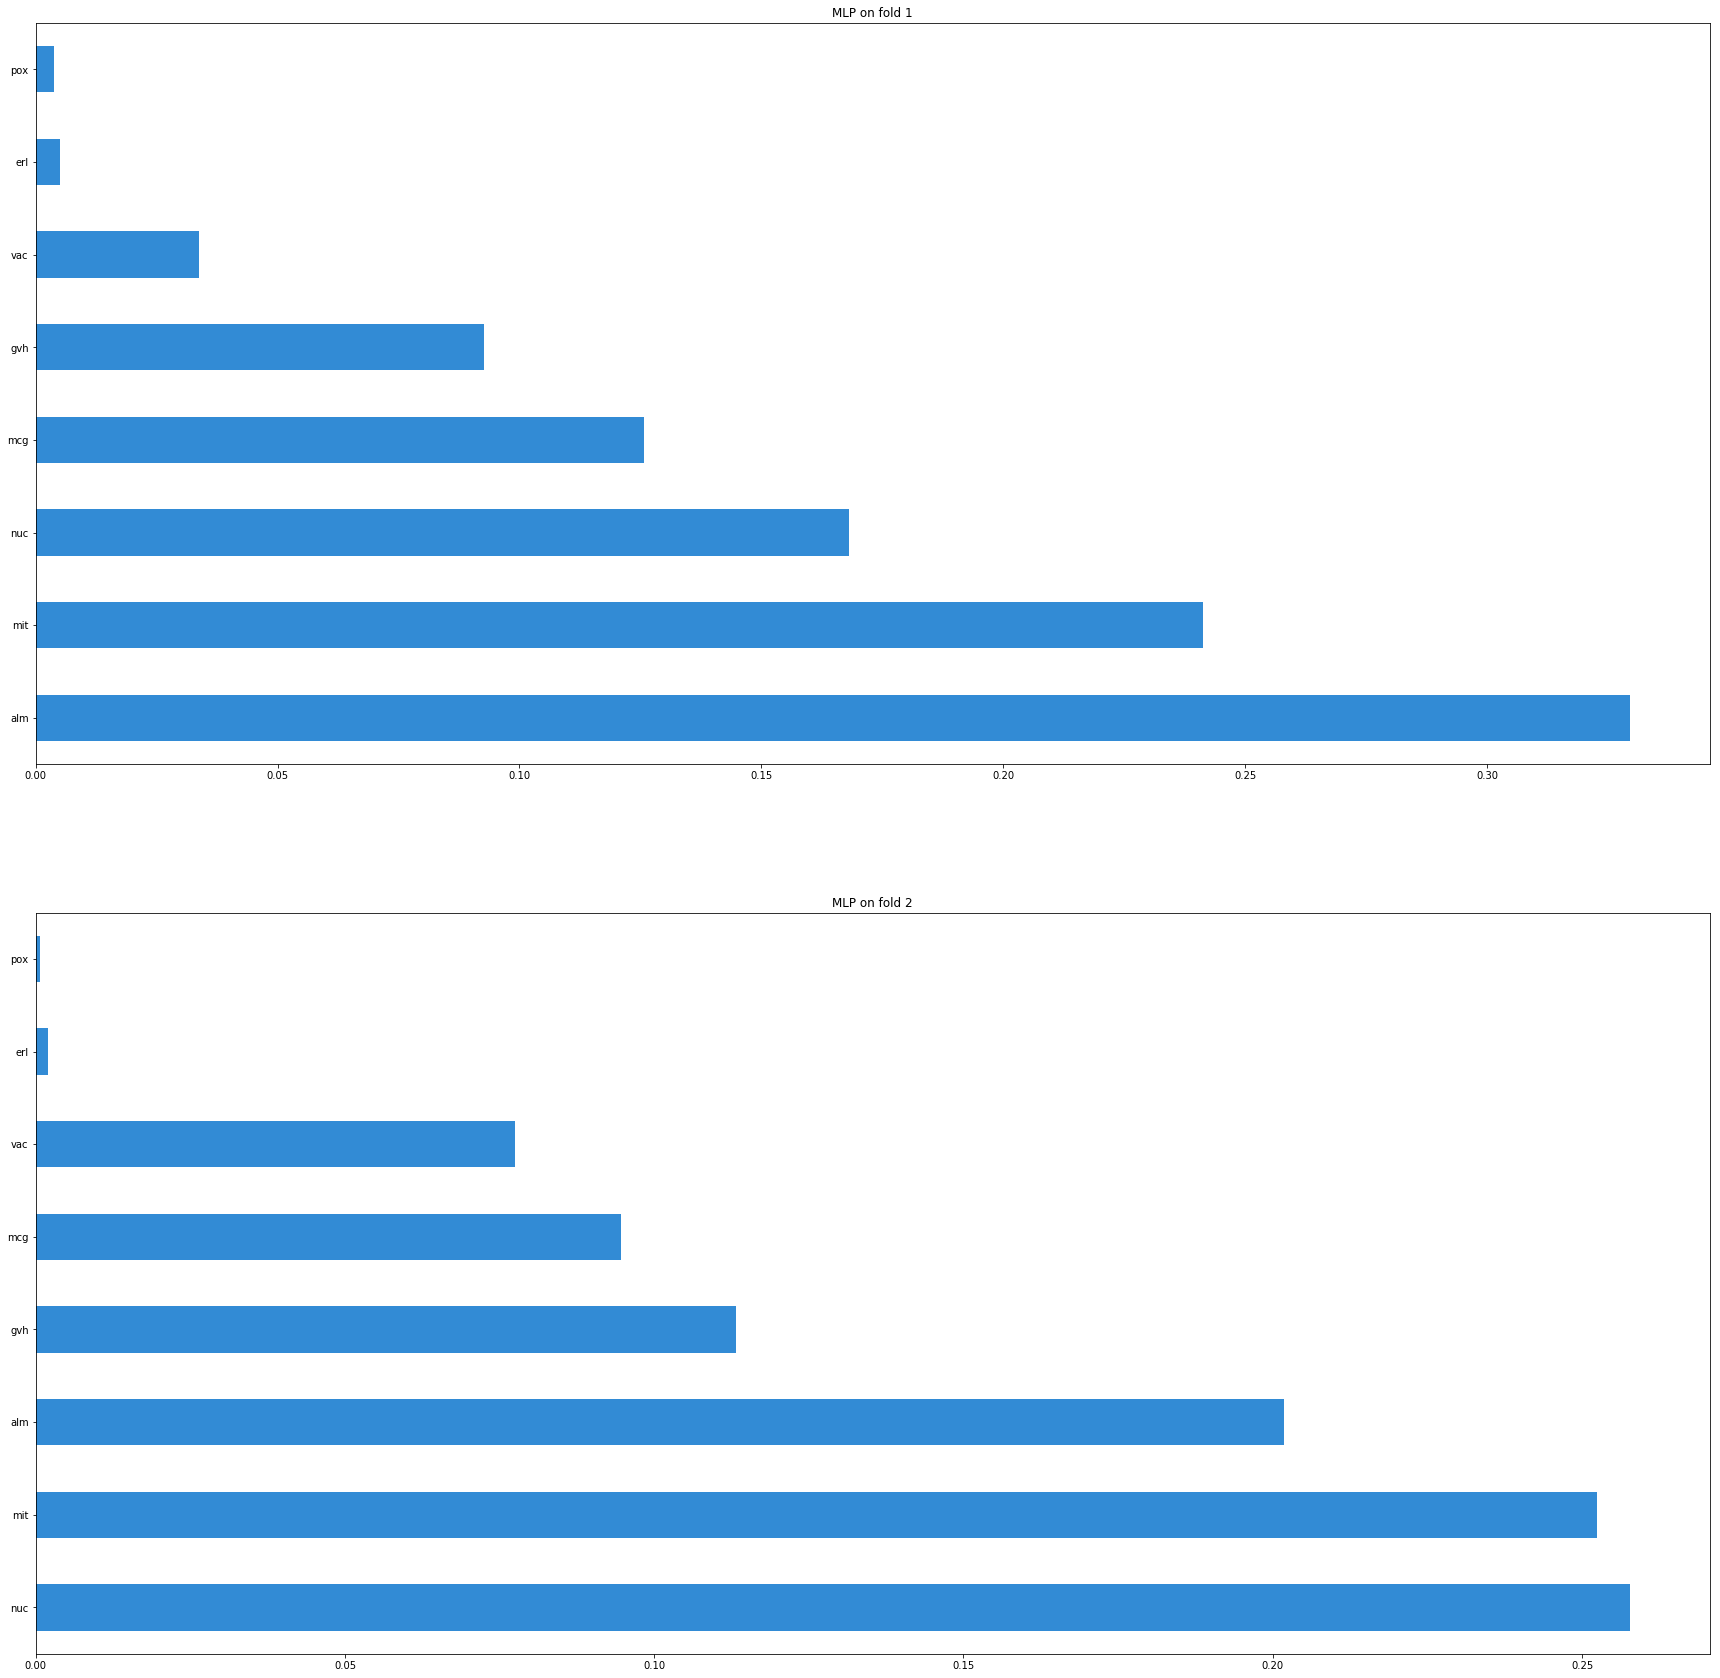

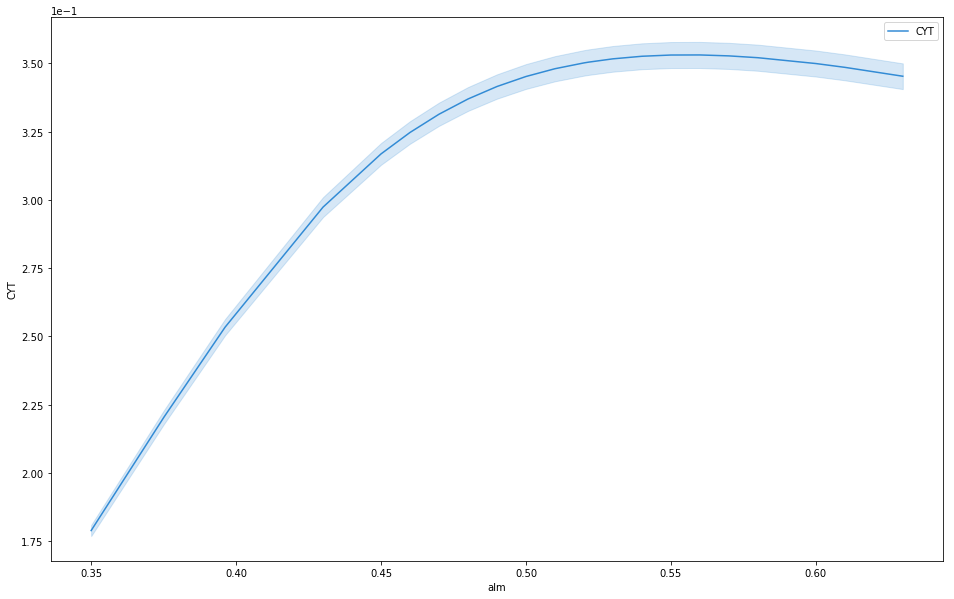

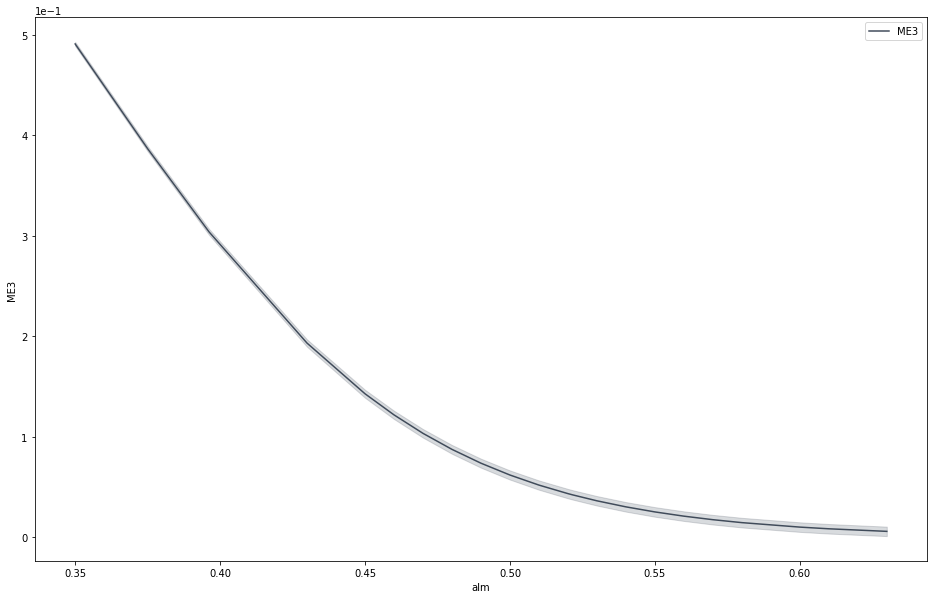

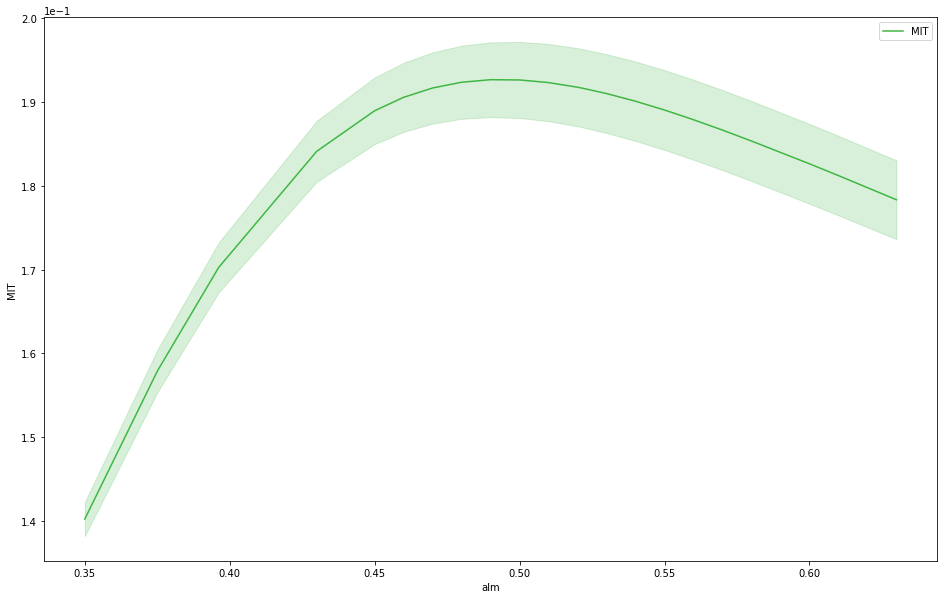

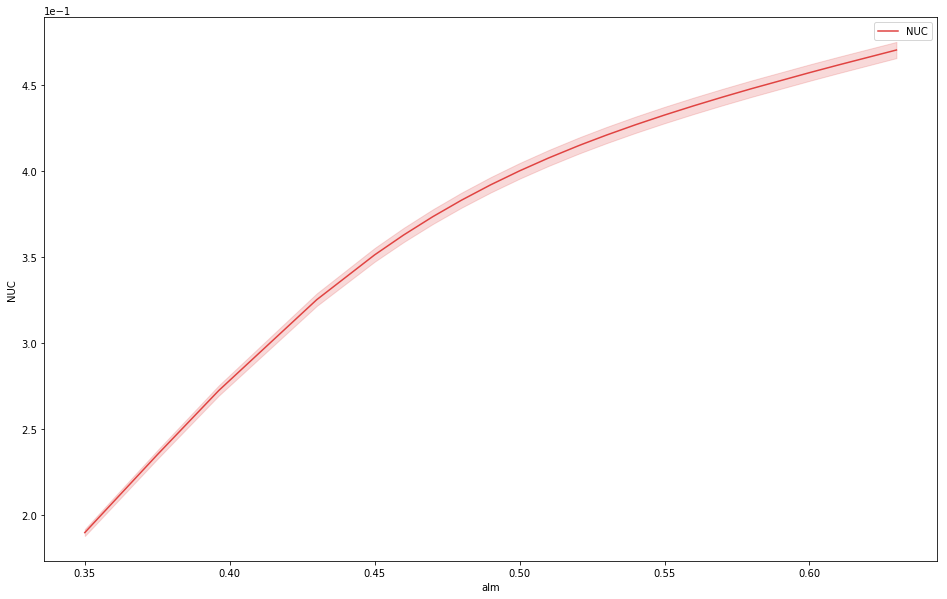

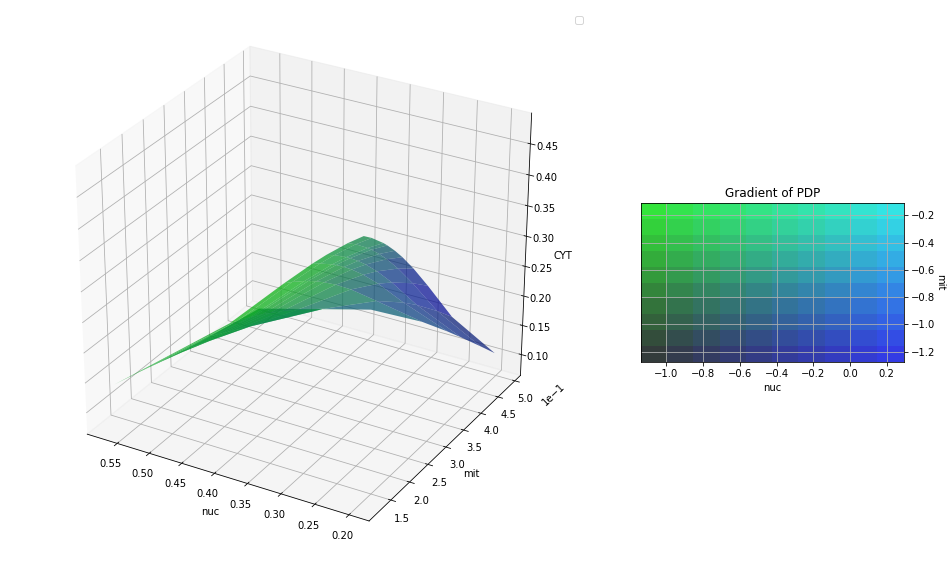

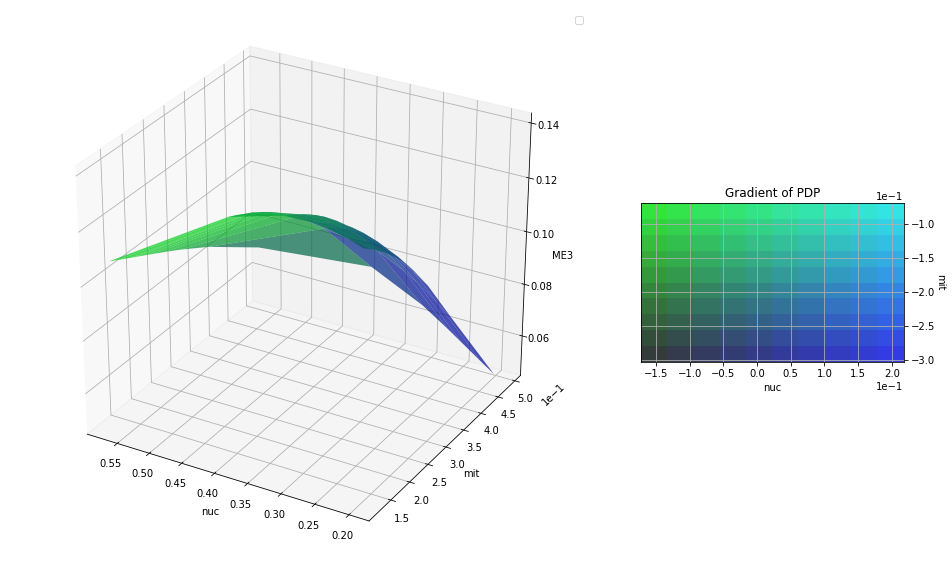

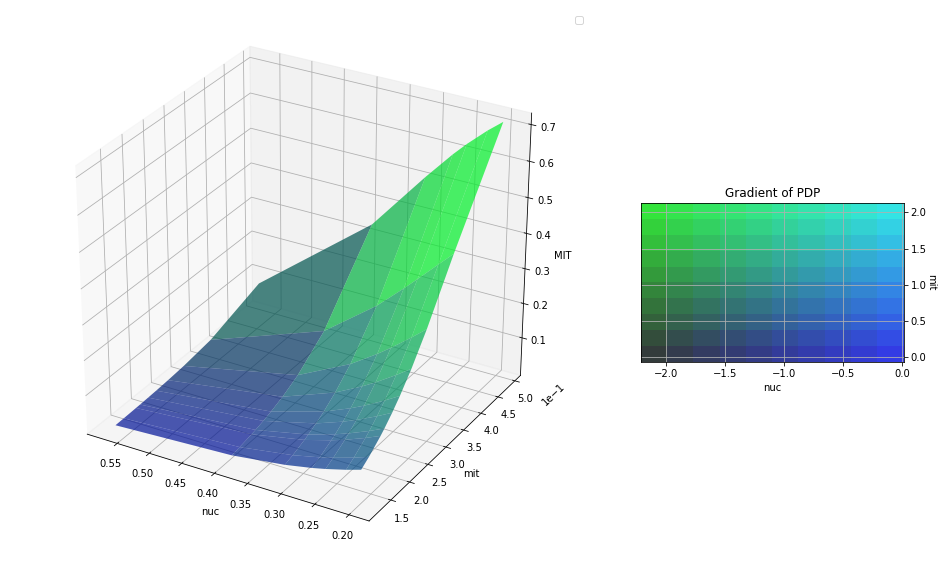

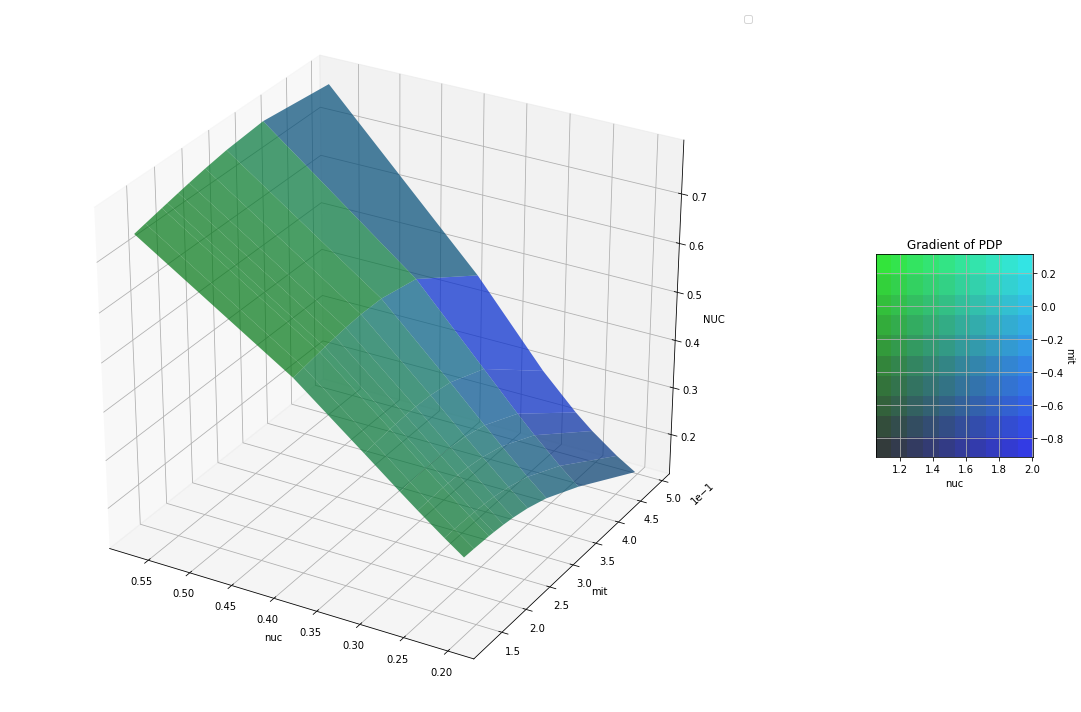

In [35]:
fold = 1
fig, axs = plt.subplots( kFold.n_splits)
for train_index, test_index in kFold.split(yeastAttrib):
    print(f"------------"
          f"Fold {fold}")
    X_train = yeast4Classes.ix[train_index]
    X_train = X_train.iloc[:, 1:9]
    train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
    test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
    prediction = dummy.predict(test_data)
    print("Dummy prediction")
    print(classification_report(test_target, prediction))
    
#     for model, title in zip(models, titles):
        
    clf = model.fit(train_data, train_target)
    prediction = clf.predict(test_data)
    print(f"{title}")
    print(classification_report(test_target, prediction))
    print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

    ax = axs[fold - 1]
    interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
    pyint_model = InMemoryModel(model.predict_proba, examples=test_data,
                                target_names=["CYT", "ME3", "MIT", "NUC"])
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=False, ax=ax,
                                                           progressbar=False)
    ax.set_title(f"{title} on fold {fold}")
    print("\n")

# ALE plots don't work together with Skater, since skater needs 3.6 and ale 3.7 ¡¡wooooohooooooo!!
#     for loc in range(len(set(train_target))):
#         print(model.classes_[loc])
#         predictor = one_class_prob_pred(model.predict_proba, loc)
#         ale_plot(model, X_train, "alm", predictor=predictor.predict, monte_carlo=True)
#         ale_plot(model, X_train, ["mit", "nuc"], predictor=predictor.predict,
#                  monte_carlo=True, monte_carlo_ratio= 0.3)

    ## To avoid clutter I only produce plots for MLP and one fold only
    if (fold==2):
        # Plot PDPs of variable "alm" since it is the most important feature
        # for other variables just change the name
        # for other models just change the number
        interpreter.partial_dependence.plot_partial_dependence(["alm"],
                                                               pyint_model, grid_resolution=30,
                                                               with_variance=True)
        # # PDP interaction between two variables, for each class
        interpreter.partial_dependence.plot_partial_dependence([("nuc", "mit")], pyint_model,
                                                               grid_resolution=10)
        DTdepth = 3
        surrogate_explainer = interpreter.tree_surrogate(oracle=pyint_model, seed=5, max_depth=DTdepth)
        surrogate_explainer.fit(train_data, train_target, use_oracle=True, prune='post', scorer_type='default')
        surrogate_explainer.plot_global_decisions(file_name=f"mlp_tree_{DTdepth}.png", fig_size=(8, 8), show_img=True)
#         plt.rcParams["figure.figsize"] = (8,8)
#         img = plt.imread(f"./mlp_tree_{DTdepth}.png")
#         plt.imshow(img)
    # couldnt figure how to put it into one subplot, since it plots directly
#     modelno += 1
    
    fold += 1
plt.rcParams["figure.figsize"] = (30,30)

We already see, on feature importance, how they change depending on the fold

![alt text](./mlp_tree_4.png "Surrogate Tree of MLP max depth 4")

In [37]:
training_sets = []
training_targets = []
testing_sets = []
testing_targets = []
for train_index, test_index in kFold.split(yeastAttrib):
    train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
    test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
    training_sets.append(train_data)
    training_targets.append(train_target)
    testing_sets.append(test_data)
    testing_targets.append(test_target)
print(f"length {len(training_sets)} shape {training_sets[0].shape}")

length 2 shape (649, 8)


In [39]:
for train_data, train_target, test_data, test_target in zip(training_sets, training_targets, 
                                                            testing_sets, testing_targets):
    prediction = dummy.predict(test_data)
    print("Dummy prediction")
    print(classification_report(test_target, prediction))

Dummy prediction
             precision    recall  f1-score   support

        CYT       0.31      0.27      0.29       198
        ERL       0.00      0.00      0.00         0
        EXC       0.00      0.00      0.00         0
        ME1       0.00      0.00      0.00         0
        ME2       0.00      0.00      0.00         0
        ME3       0.15      0.12      0.13        75
        MIT       0.29      0.26      0.27       180
        NUC       0.28      0.23      0.25       197
        POX       0.00      0.00      0.00         0
        VAC       0.00      0.00      0.00         0

avg / total       0.27      0.24      0.25       650

Dummy prediction
             precision    recall  f1-score   support

        CYT       0.40      0.25      0.30       265
        ERL       0.00      0.00      0.00         0
        EXC       0.00      0.00      0.00         0
        ME1       0.00      0.00      0.00         0
        ME2       0.00      0.00      0.00         0
        

In [40]:
for train_data, train_target, test_data, test_target in zip(training_sets, training_targets, 
                                                            testing_sets, testing_targets):
    clf = model.fit(train_data, train_target)
    prediction = clf.predict(test_data)
    print(f"{title}")
    print(classification_report(test_target, prediction))
    print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

MLP
             precision    recall  f1-score   support

        CYT       0.41      0.64      0.50       198
        ME3       0.78      0.80      0.79        75
        MIT       0.80      0.39      0.53       180
        NUC       0.56      0.50      0.53       197

avg / total       0.60      0.55      0.55       650

Confusion Matrix: 
 [[126   2   8  62]
 [  6  60   1   8]
 [ 91  11  71   7]
 [ 86   4   9  98]]
MLP
             precision    recall  f1-score   support

        CYT       0.58      0.55      0.56       265
        ME3       0.90      0.70      0.79        88
        MIT       0.35      0.59      0.44        64
        NUC       0.61      0.58      0.59       232

avg / total       0.61      0.58      0.59       649

Confusion Matrix: 
 [[145   0  53  67]
 [ 15  62   3   8]
 [ 13   2  38  11]
 [ 78   5  15 134]]


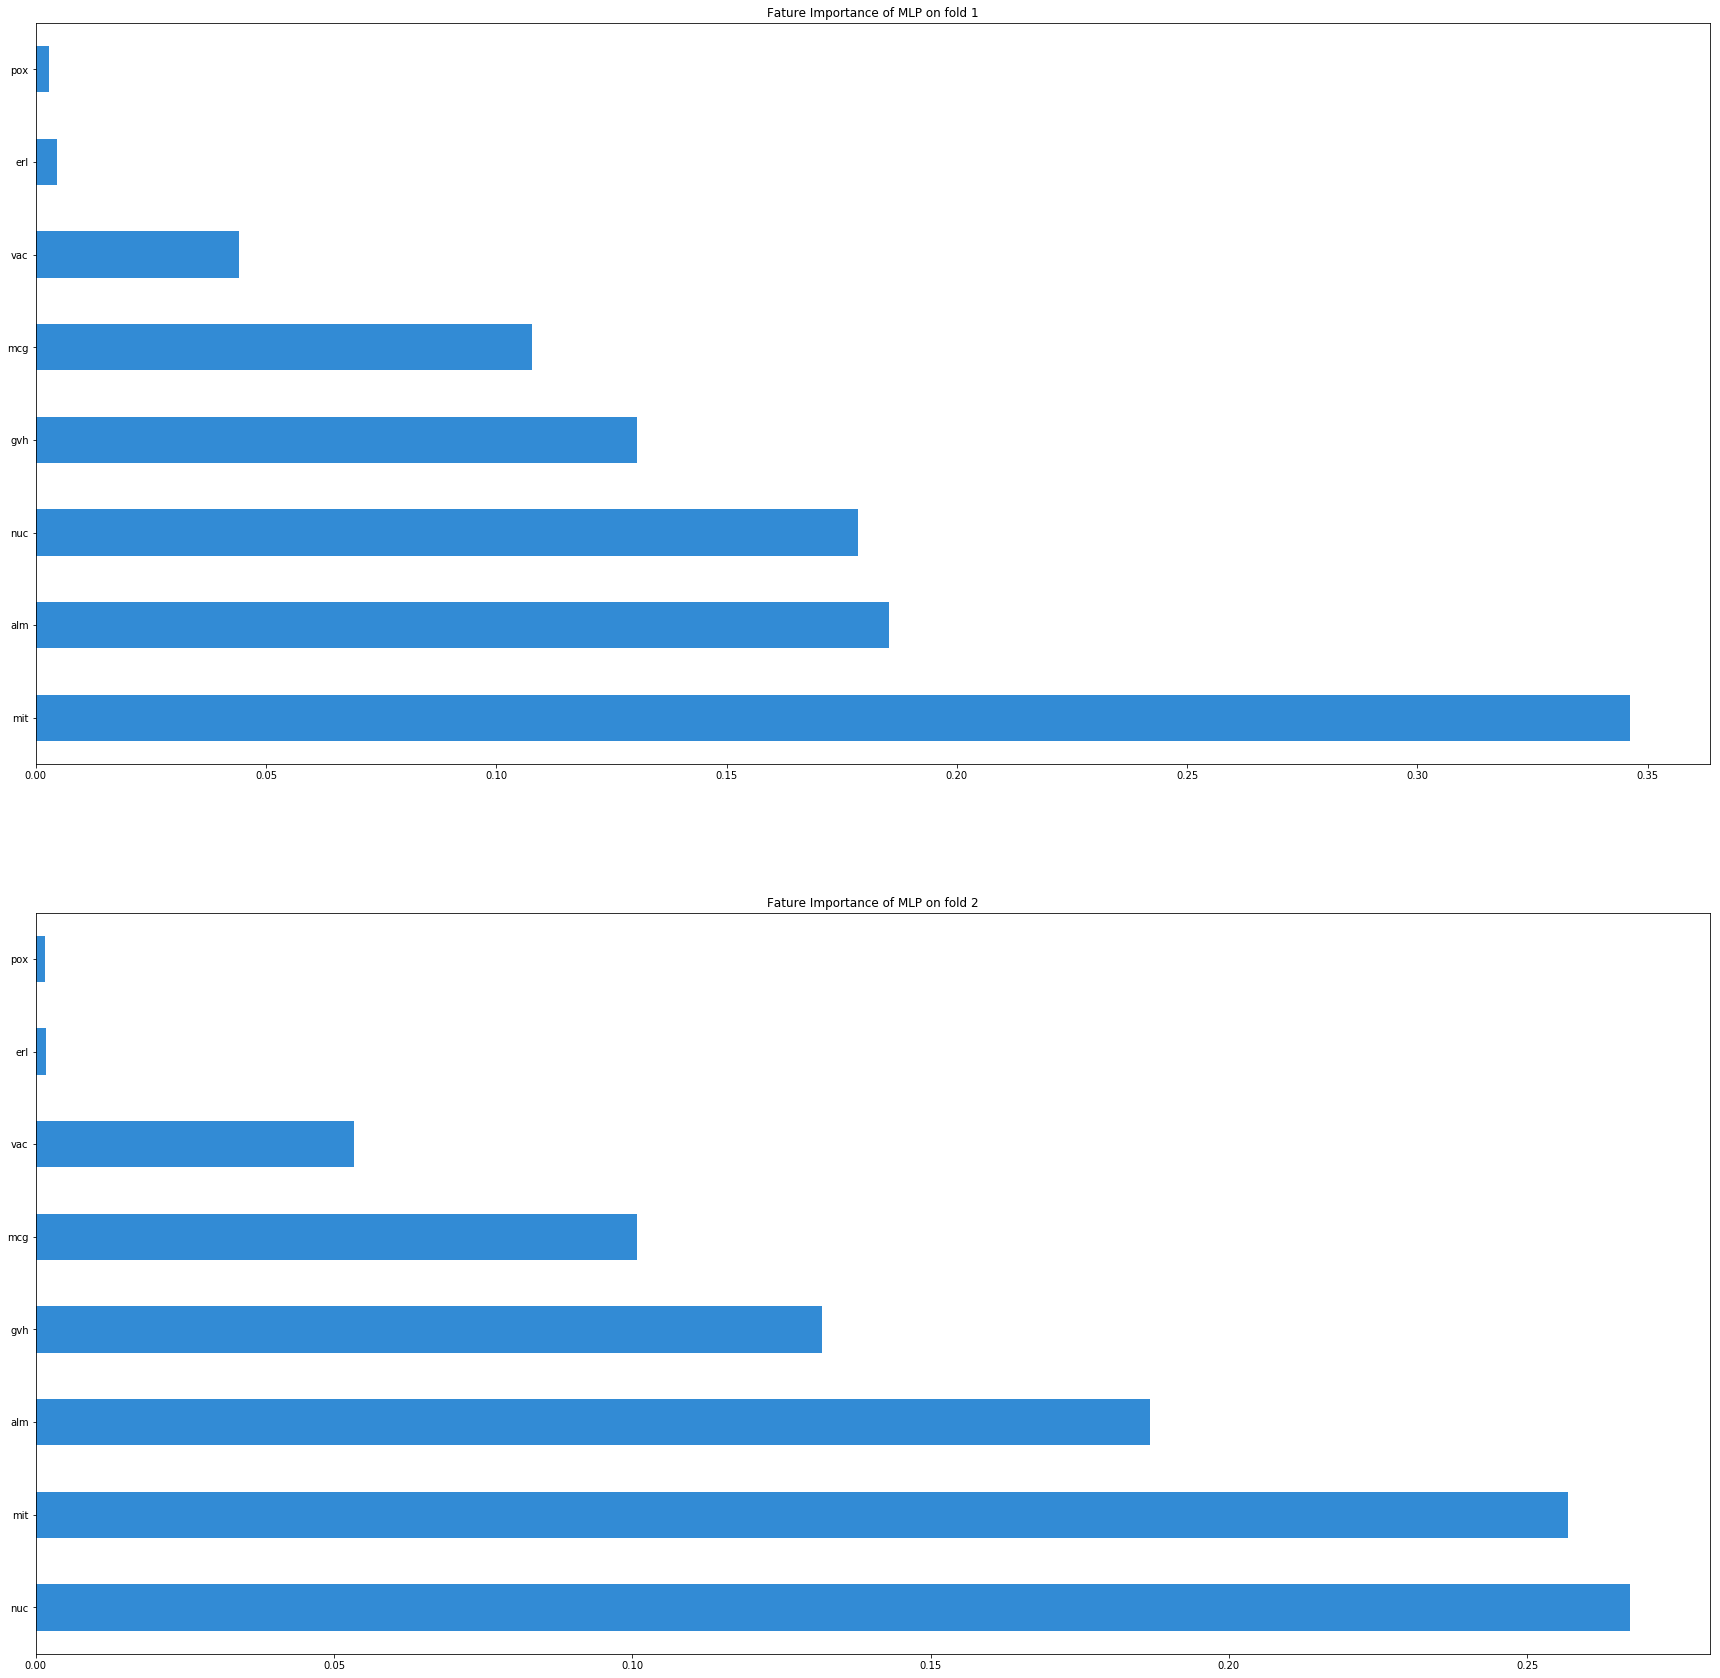

In [44]:
fig, axs = plt.subplots( kFold.n_splits)
fold = 1
for train_data, train_target, test_data, test_target in zip(training_sets, training_targets, 
                                                            testing_sets, testing_targets):
    ax = axs[fold - 1]
    interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
    pyint_model = InMemoryModel(model.predict_proba, examples=test_data,
                                target_names=["CYT", "ME3", "MIT", "NUC"])
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=False, ax=ax,
                                                           progressbar=False)
    ax.set_title(f"Fature Importance of MLP on fold {fold}")
    fold +=1 

2019-07-05 22:12:58,349 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[23/23] grid cells ████████████████████ Time elapsed: 1 seconds

2019-07-05 22:13:00,180 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[70/70] grid cells ████████████████████ Time elapsed: 5 seconds

2019-07-05 22:13:06,357 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[22/22] grid cells ████████████████████ Time elapsed: 1 seconds

2019-07-05 22:13:08,322 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[70/70] grid cells ████████████████████ Time elapsed: 5 seconds

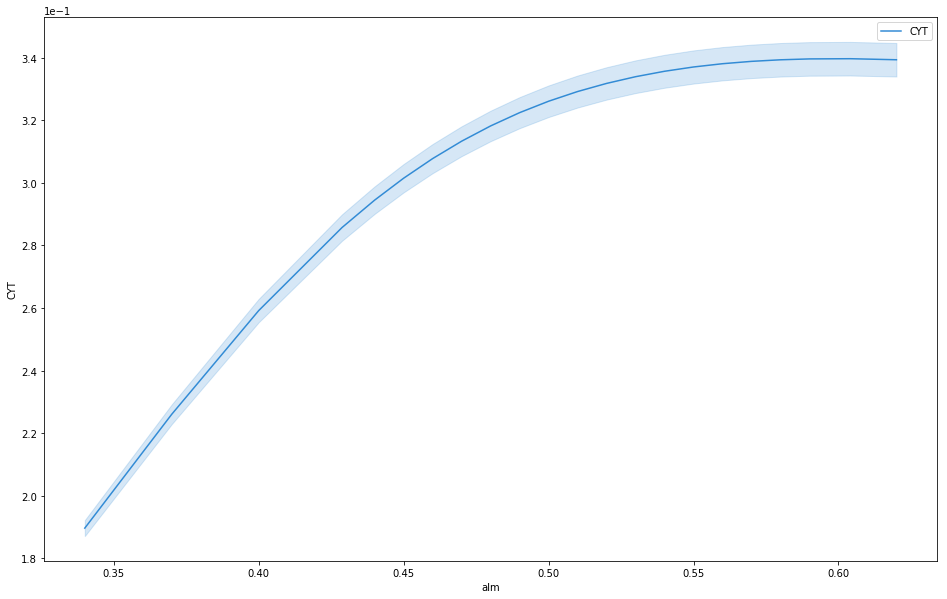

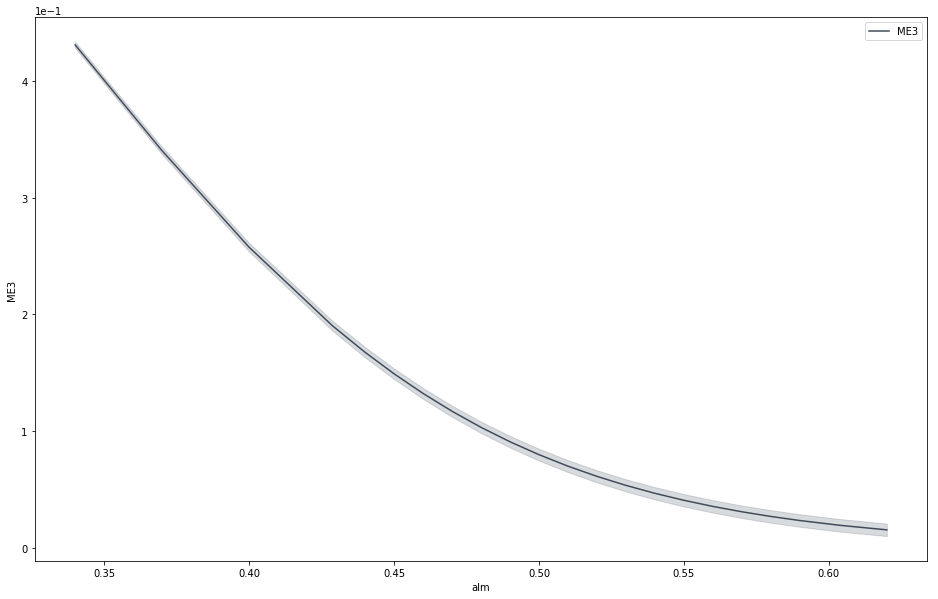

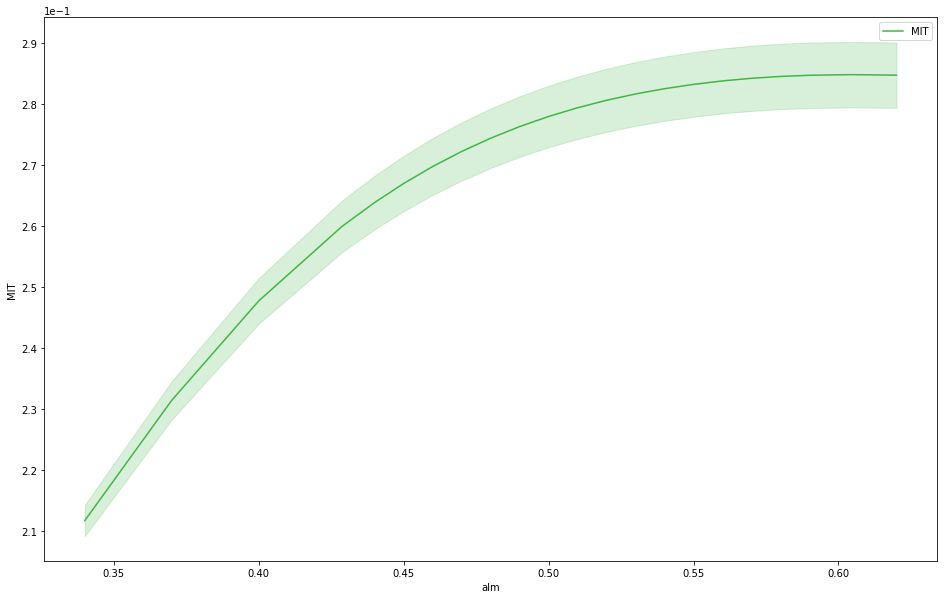

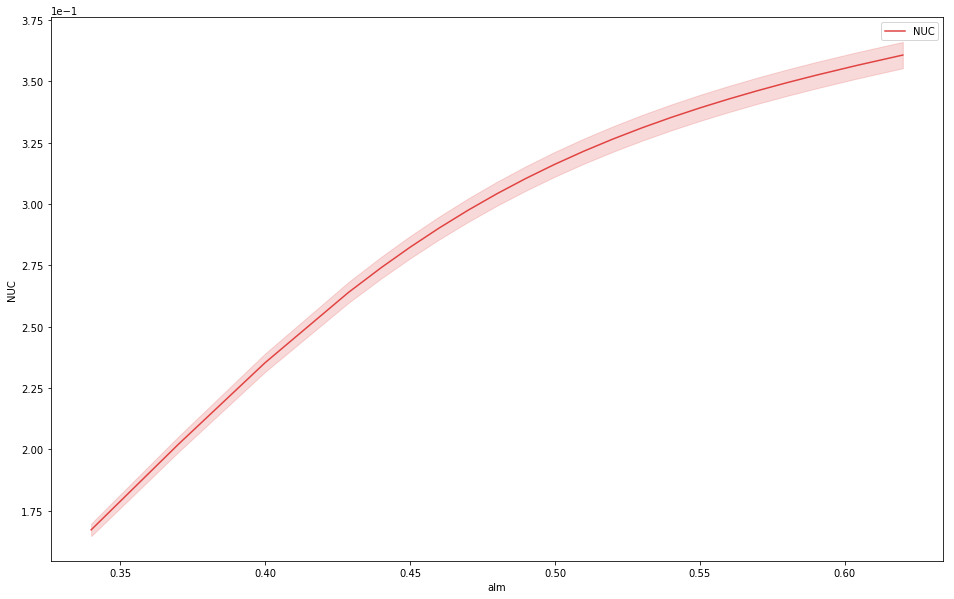

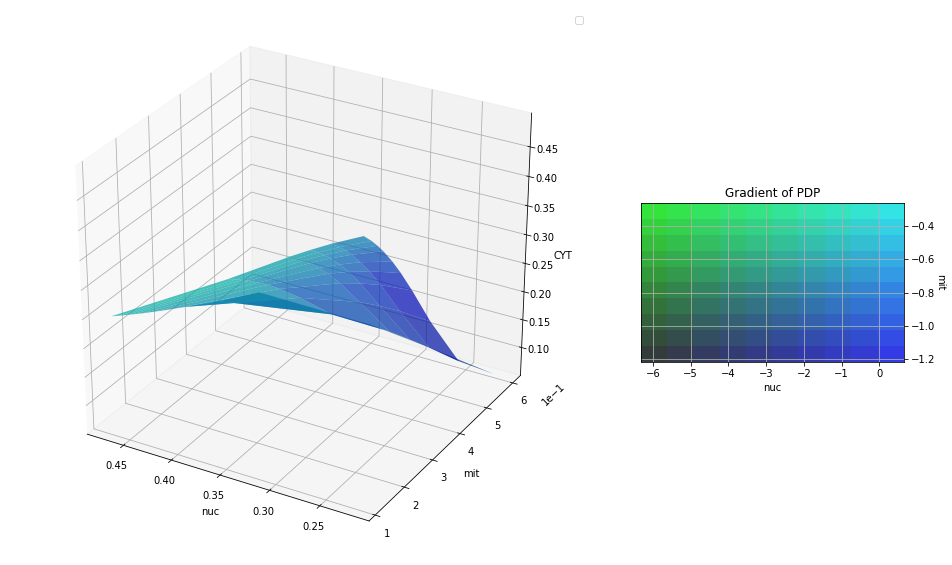

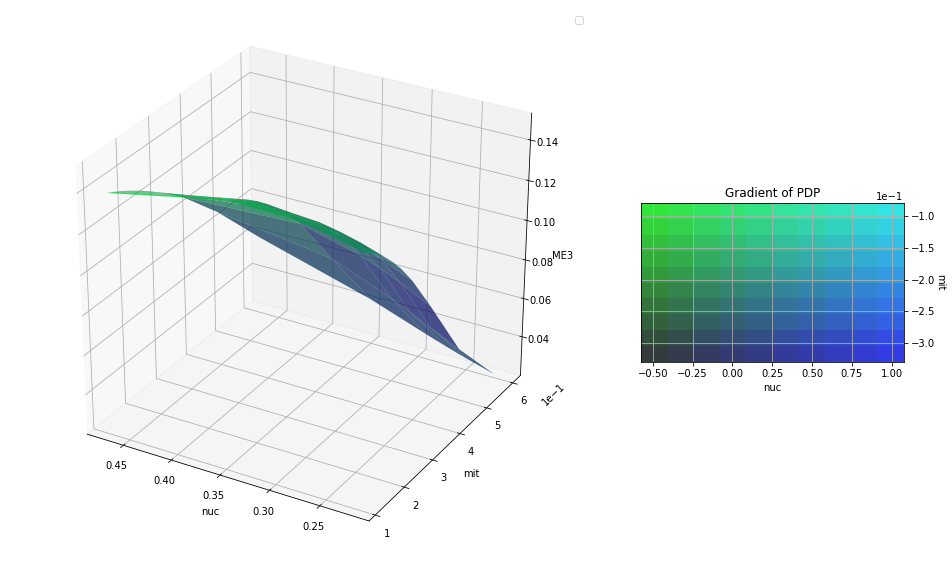

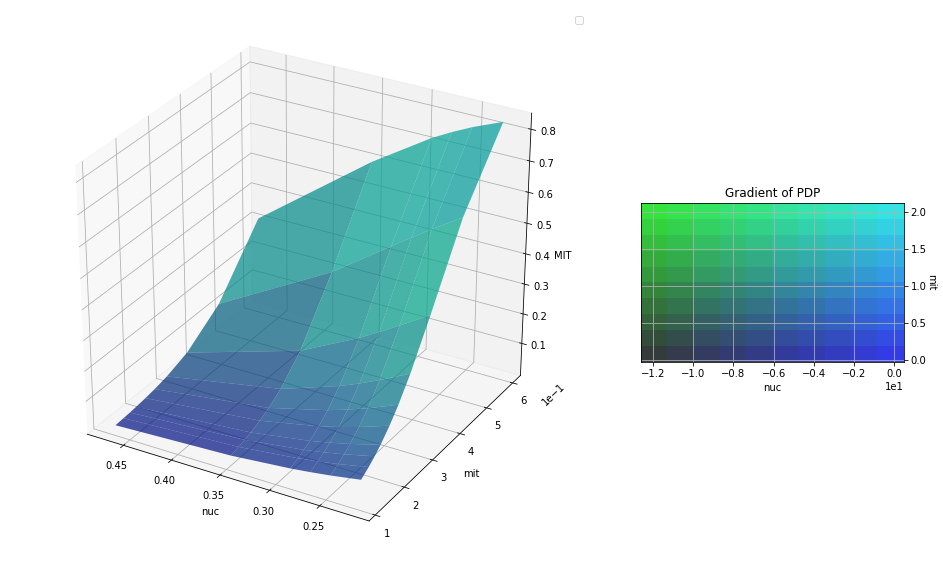

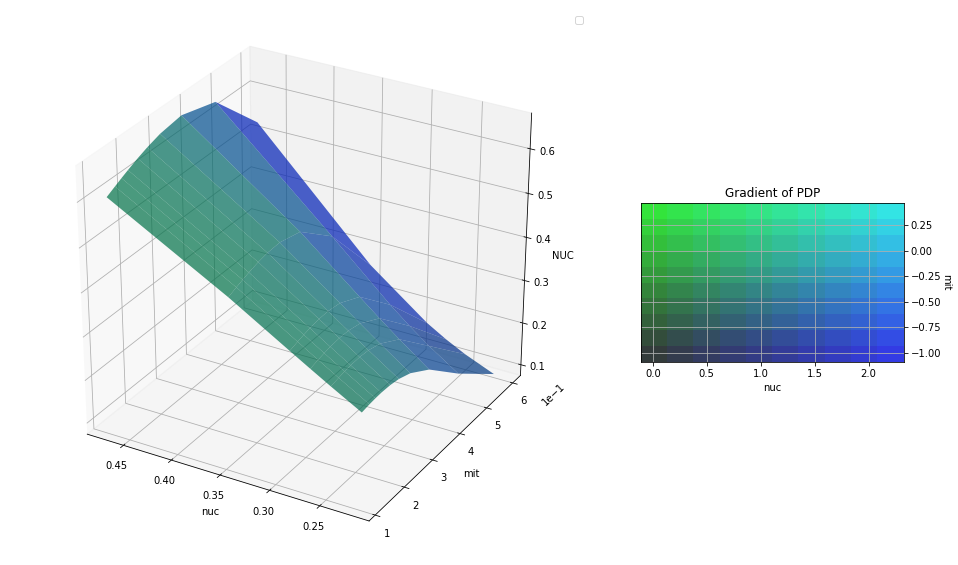

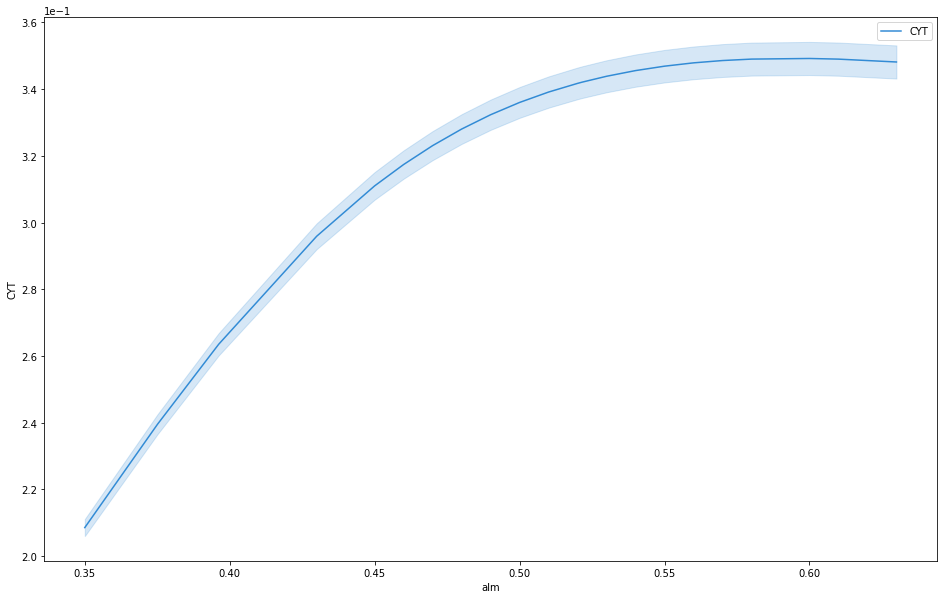

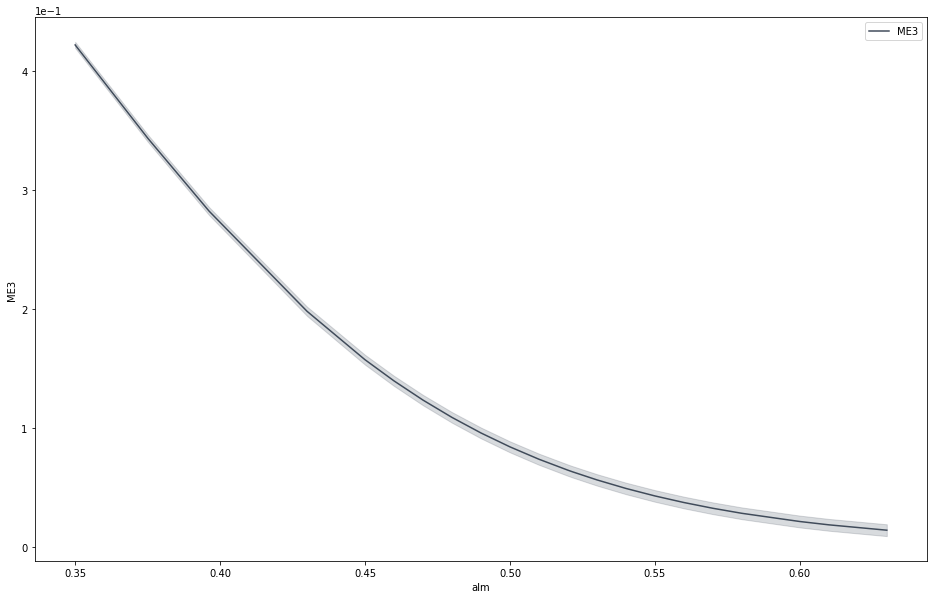

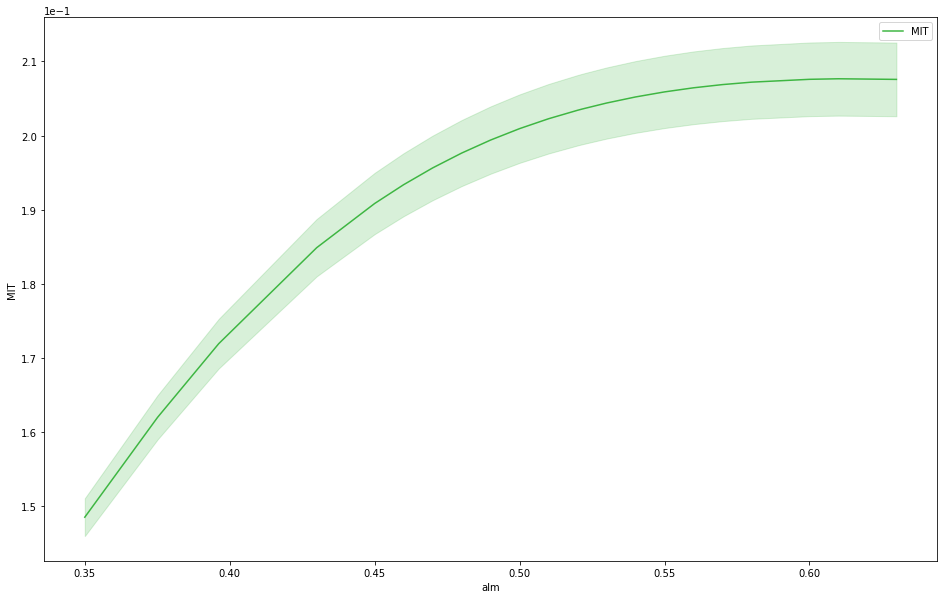

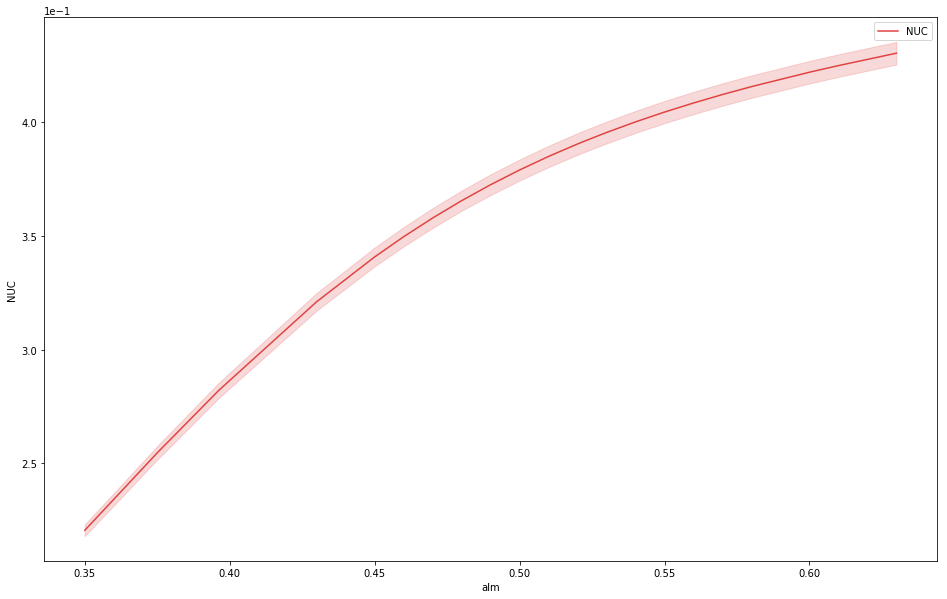

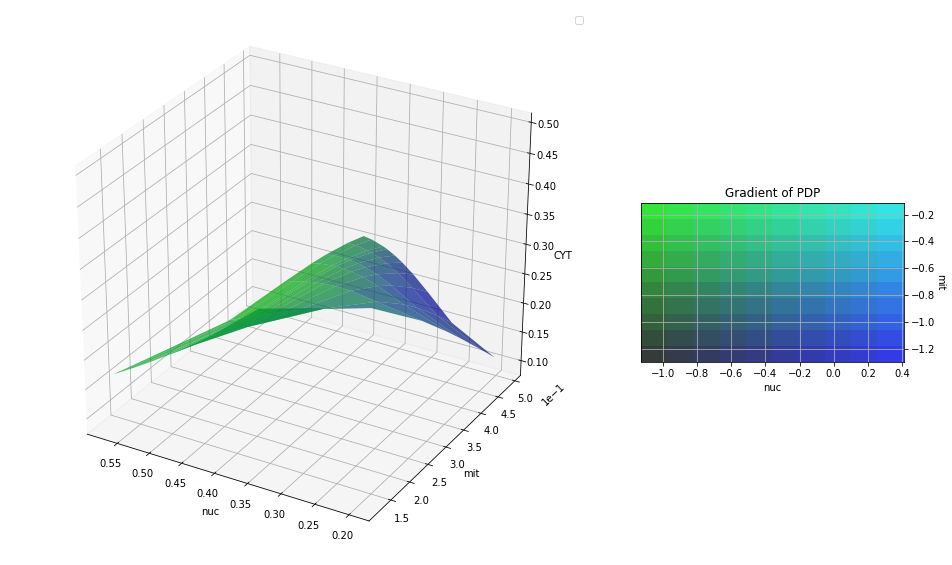

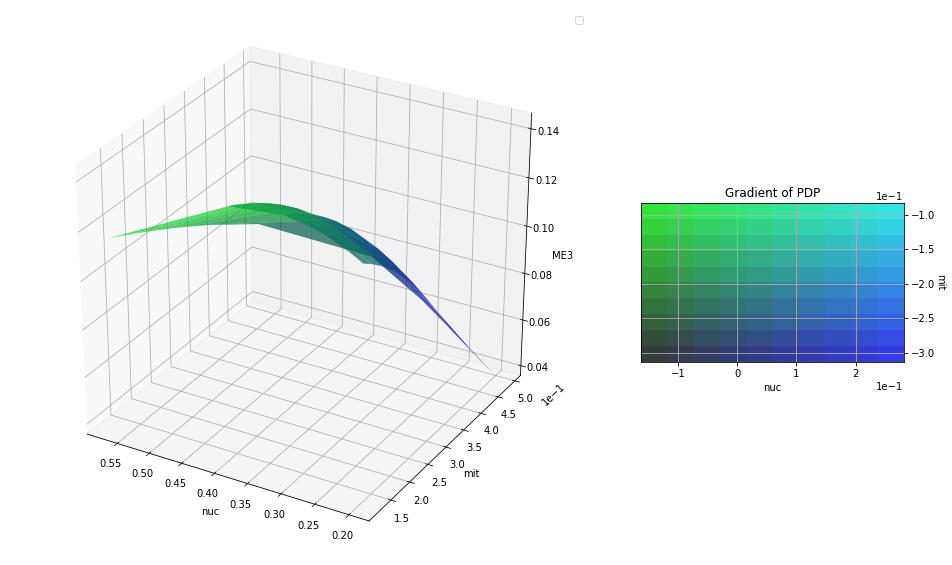

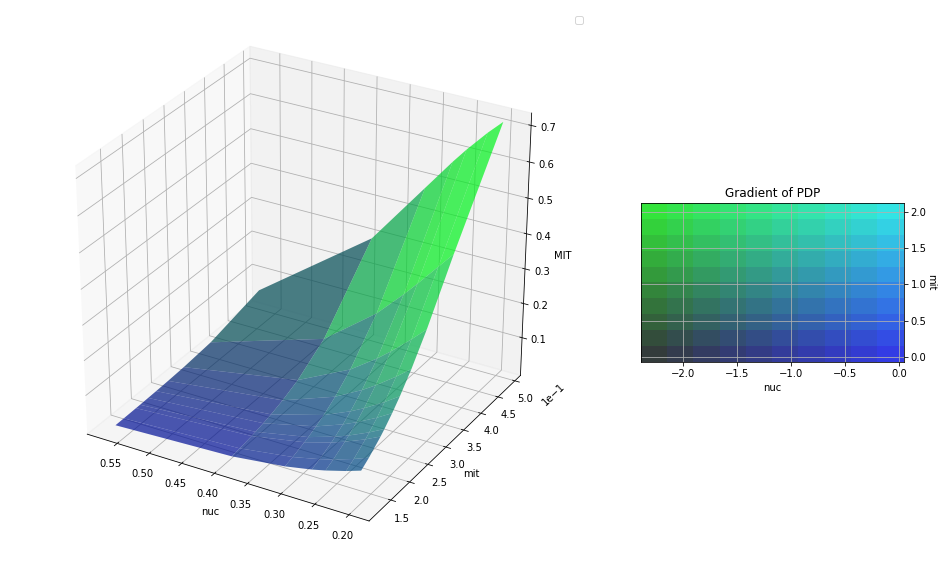

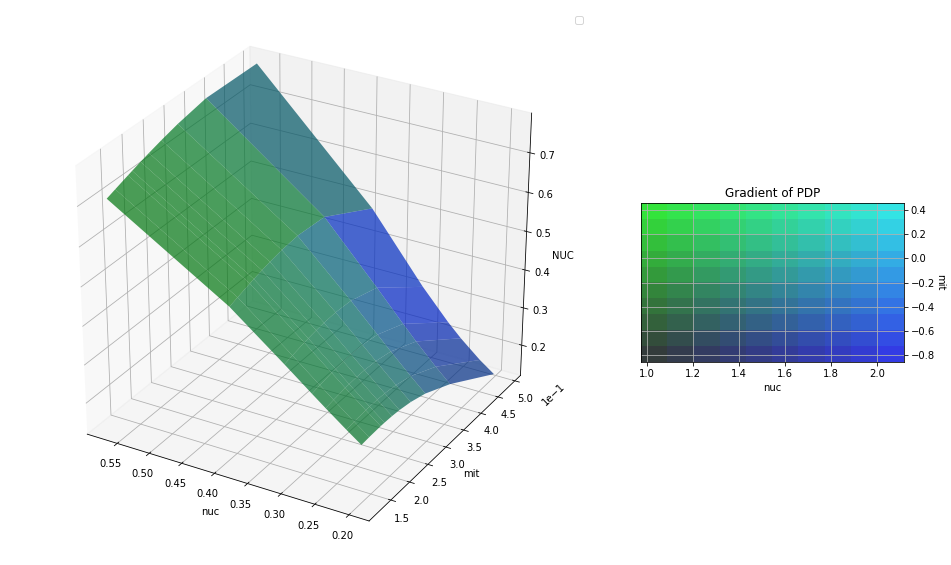

In [45]:
# PD Plots
for train_data, train_target, test_data, test_target in zip(training_sets, training_targets, 
                                                            testing_sets, testing_targets):
    interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
    pyint_model = InMemoryModel(model.predict_proba, examples=test_data,
                                target_names=["CYT", "ME3", "MIT", "NUC"])
    # for other variables just change the name
    # for other models just change the number
    interpreter.partial_dependence.plot_partial_dependence(["alm"],
                                                           pyint_model, grid_resolution=30,
                                                           with_variance=True)
    # # PDP interaction between two variables, for each class
    interpreter.partial_dependence.plot_partial_dependence([("nuc", "mit")], pyint_model,
                                                           grid_resolution=10)

In [ ]:
# ALE plots don't work together with Skater, since skater needs 3.6 and ale 3.7 ¡¡wooooohooooooo!!

# X_train must be a dataframe, not np.array like the rest 
# for train_data, train_target, test_data, test_target in zip(training_sets, training_targets, 
#                                                             testing_sets, testing_targets):
#     for loc in range(len(set(train_target))):
#         print(model.classes_[loc])
#         predictor = one_class_prob_pred(model.predict_proba, loc)
#         ale_plot(model, X_train, "alm", predictor=predictor.predict, monte_carlo=True)
#         ale_plot(model, X_train, ["mit", "nuc"], predictor=predictor.predict,
#                  monte_carlo=True, monte_carlo_ratio= 0.3)

2019-07-05 22:22:54,144 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2019-07-05 22:22:54,148 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2019-07-05 22:22:54,152 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 0.825958395586175
2019-07-05 22:22:54,160 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed []
2019-07-05 22:22:54,162 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (649, 4)
2019-07-05 22:22:54,170 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.826; oracle score 0.992
2019-07-05 22:22:54,172 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.166 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is th

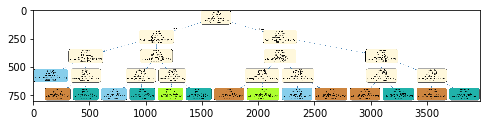

In [48]:
fold = 1
for train_data, train_target, test_data, test_target in zip(training_sets, training_targets, 
                                                            testing_sets, testing_targets):
    interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
    pyint_model = InMemoryModel(model.predict_proba, examples=test_data,
                                target_names=["CYT", "ME3", "MIT", "NUC"])
    for DTdepth in range(2,5):
        surrogate_explainer = interpreter.tree_surrogate(oracle=pyint_model, seed=5, max_depth=DTdepth)
        surrogate_explainer.fit(train_data, train_target, use_oracle=True, prune='post', scorer_type='default')
        surrogate_explainer.plot_global_decisions(file_name=f"mlp_tree_{DTdepth}_{fold}.png",
                                                  fig_size=(8, 8), show_img=True)
    fold += 1

### The bigger the difference between scores, the worse the explanation

### Surrogate score 0.826; oracle score 0.992
![alt text](./mlp_tree_2_1.png "Surrogate Tree of MLP max depth 2")

### Surrogate score 0.594; oracle score 0.992
![alt text](./mlp_tree_3_1.png "Surrogate Tree of MLP max depth 3")

### Surrogate score 0.474; oracle score 0.992
![alt text](./mlp_tree_4_1.png "Surrogate Tree of MLP max depth 4")



In [7]:
#Remove observations, do the same